# Прогнозирование временных рядов с использованием модели Хольта-Винтерса

## Цель работы

Целью данной работы является разработка и реализация модели Хольта-Уинтерса для прогнозирования временных рядов с сезонными и трендовыми компонентами. В процессе выполнения работы также будет проведён подбор гиперпараметров модели (параметры сглаживания и длина сезона) с использованием методов машинного обучения для минимизации ошибки прогнозирования.

## Постановка задачи

1. **Разработать реализацию модели Хольта-Винтерса**:
   - Модель должна учитывать компоненты сезонности и тренда.

2. **Инициализировать основные компоненты модели**:
   - Уровень.
   - Тренд.
   - Сезонные паттерны.

3. **Выполнить оптимизацию гиперпараметров модели**:
   - Параметры сглаживания ($ \alpha, \beta, \gamma $).
   - Длину сезона ($ \text{season\_length} $, опционально).

4. **Оценить качество модели**:
   - Использовать метрики RMSE, MAPE для сравнения фактических и прогнозируемых значений.

---

### Модель Хольта-Винтерса и оптимизация параметров

Модель Хольта-Винтерса предназначена для прогнозирования временных рядов, содержащих **тренд** и **сезонность**. Она состоит из трёх ключевых компонент:

1. **Уровень** ( $ L_t $ ): базовое значение ряда на текущий момент.
2. **Тренд** ( $ T_t $ ): направление и скорость изменения уровня.
3. **Сезонность** ( $ S_t $ ): повторяющиеся паттерны, зависящие от времени года, месяца или другого цикла.

#### Основная формула прогноза
Для прогнозирования значения через $ h $ шагов вперёд используется следующая формула:

$$
\hat{y}_{t+h} = \big( L_t + h \cdot T_t \big) \cdot S_{(t+h) \mod \text{season\_length}}
$$

где:
- $ \hat{y}_{t+h} $ — прогнозируемое значение через $ h $-шагов вперёд,
- $ L_t $ — уровень на момент времени $ t $,
- $ T_t $ — тренд на момент времени $ t $,
- $ S_{(t+h) \mod \text{season\_length}} $ — значение сезонности для соответствующего цикла.

---

#### Обновление компонент модели

1. **Уровень**:
   $$
   L_t = \alpha \cdot \frac{y_t}{S_{t \mod \text{season\_length}}} + (1 - \alpha) \cdot (L_{t-1} + T_{t-1})
   $$
   Здесь:
   - $ y_t $ — фактическое значение временного ряда,
   - $ \alpha $ — коэффициент сглаживания уровня ($ 0 < \alpha < 1 $).

2. **Тренд**:
   $$
   T_t = \beta \cdot (L_t - L_{t-1}) + (1 - \beta) \cdot T_{t-1}
   $$
   Здесь:
   - $ \beta $ — коэффициент сглаживания тренда ($ 0 < \beta < 1 $).

3. **Сезонность**:
   $$
   S_{t \mod \text{season\_length}} = \gamma \cdot \frac{y_t}{L_t} + (1 - \gamma) \cdot S_{t \mod \text{season\_length}}
   $$
   Здесь:
   - $ \gamma $ — коэффициент сглаживания сезонности ($ 0 < \gamma < 1 $).

In [110]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import differential_evolution, minimize

import warnings
warnings.filterwarnings('ignore')

In [111]:
data = pd.read_excel('data/VVP_kvartal_s_1995-2024.xlsx')[:-16]

quarter_mapping = {'I квартал': 'Q1', 'II квартал': 'Q2', 'III квартал': 'Q3', 'IV квартал': 'Q4'}
data['Quarter'] = data['Quarter'].map(quarter_mapping)
data['Date'] = pd.to_datetime(data['Year'].astype(str) + data['Quarter'])

# Сортировка по дате
data.drop(['Year', 'Quarter'], axis=1, inplace=True)
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)

Оптимизация параметров модели...



Оптимальные параметры:
alpha (уровень): 0.7431
beta (тренд): 0.0001
gamma (сезонность): 0.8264
Длина сезона: 4

Метрики качества модели:
RMSE: 366.31
MAPE: 1.24%


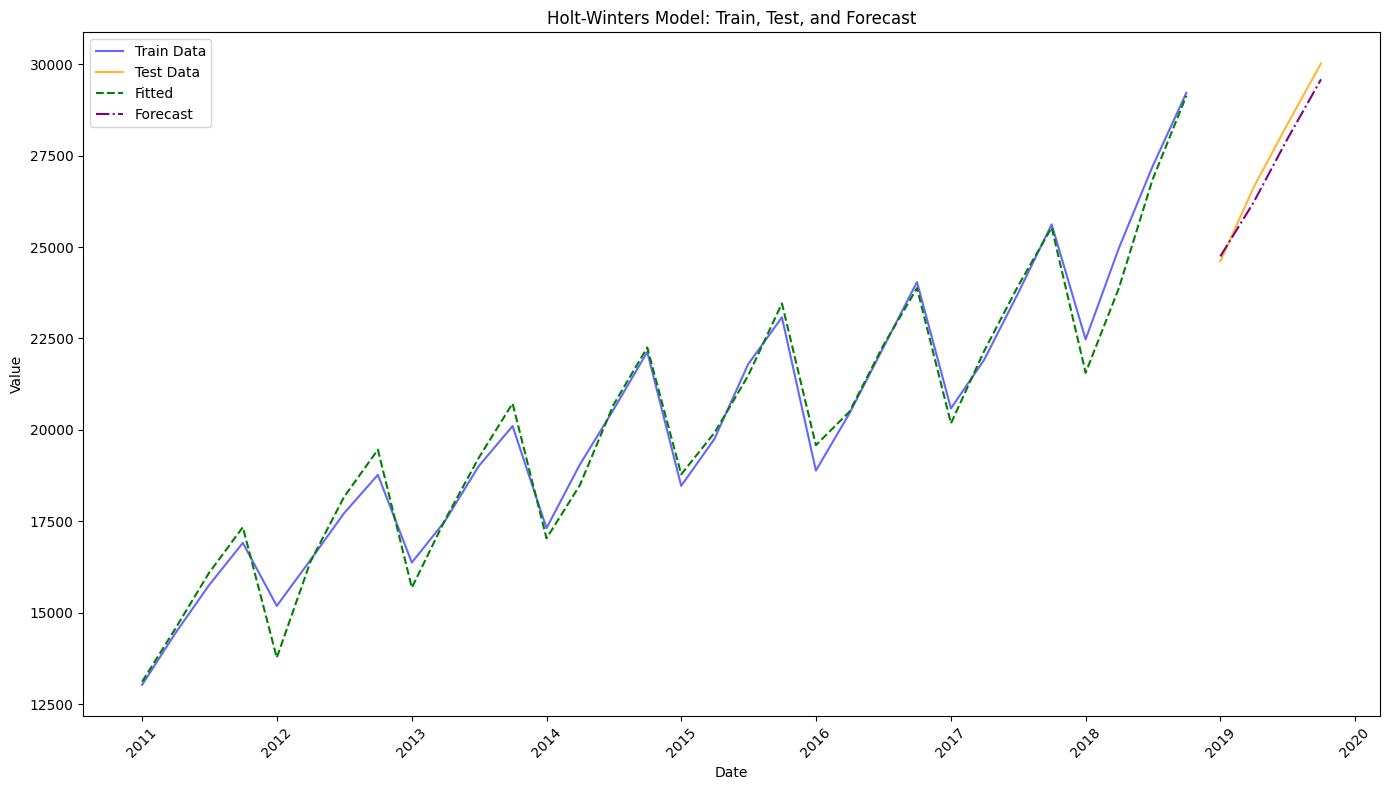

In [112]:
class HoltWintersMultiplicative:
    def __init__(self, series, season_length=12, alpha=None, beta=None, gamma=None):
        self.series = np.array(series)
        self.season_length = season_length
        self.alpha = alpha if alpha is not None else 0.3
        self.beta = beta if beta is not None else 0.1
        self.gamma = gamma if gamma is not None else 0.1
        
        self.trend = None
        self.level = None
        self.seasonal = None
        self.fitted = None
        self.residuals = None
        self.mse = None
        
    def initialize_components(self):
        # Расчет количетсва сезонов. For example: 40 кварталов / длина сезона (4) = 10 сезонов
        n_seasons = len(self.series) // self.season_length
        
        # Инициализация сезонной компоненты. То есть создание массива средних значений сезонов.
        seasonal_averages = np.zeros(self.season_length)
        for i in range(self.season_length):
            season_slice = self.series[i::self.season_length][:n_seasons]
            seasonal_averages[i] = np.mean(season_slice)
        
        # Нормализация сезонной компоненты
        self.seasonal = seasonal_averages / np.mean(seasonal_averages)
        
        # Инициализация уровня и тренда
        deseasoned = self.series[:(n_seasons * self.season_length)] / \
                     np.tile(self.seasonal, n_seasons)
        
        x = np.arange(len(deseasoned))
        # Примерение линейной регресии для инициализации тренда и уровня
        coeffs = np.polyfit(x, deseasoned, 1)
        self.trend = coeffs[0]
        self.level = coeffs[1]
    
    def fit(self):
        self.initialize_components()
        n = len(self.series)
        self.fitted = np.zeros(n)
        
        for t in range(n):
            if t == 0:
                self.fitted[t] = self.level * self.seasonal[t % self.season_length]
                continue
                
            # Прогноз на текущий шаг
            self.fitted[t] = (self.level + self.trend) * \
                             self.seasonal[t % self.season_length]
                        
            # Обновление компонент
            old_level = self.level
            self.level = self.alpha * (self.series[t] / self.seasonal[t % self.season_length]) + \
                         (1 - self.alpha) * (old_level + self.trend)
            
            self.trend = self.beta * (self.level - old_level) + \
                         (1 - self.beta) * self.trend
            
            self.seasonal[t % self.season_length] = self.gamma * \
                                                    (self.series[t] / self.level) + \
                                                    (1 - self.gamma) * \
                                                    self.seasonal[t % self.season_length]
        
        self.residuals = self.series - self.fitted
        self.mse = mean_squared_error(self.series, self.fitted)
        return self
    
    def forecast(self, h=1):
        forecasts = np.zeros(h)
        for t in range(h):
            forecasts[t] = (self.level + self.trend) * \
                           self.seasonal[(len(self.series) + t) % self.season_length]
        return forecasts

def optimize_parameters(series, max_season_length=24):
    """
    Оптимизация параметров с использованием дифференциальной эволюции.
    """
    def objective(params):
        alpha, beta, gamma, s_length = params
        s_length = int(s_length)  # Преобразуем в целое число

        if not (0 < alpha < 1 and 0 < beta < 1 and 0 < gamma < 1):
            return float('inf')

        if not (1 <= s_length <= max_season_length):
            return float('inf')

        try:
            model = HoltWintersMultiplicative(series, season_length=s_length,
                                              alpha=alpha, beta=beta, gamma=gamma)
            model.fit()
            return model.mse
        except:
            return float('inf')

    # Диапазоны для параметров
    bounds = [
        (0.0001, 0.9999),  # alpha
        (0.0001, 0.9999),  # beta
        (0.0001, 0.9999),  # gamma
        (1, max_season_length)  # s_length
    ]

    # Оптимизация
    result = differential_evolution(objective, bounds, strategy='best1bin', 
                                    maxiter=1000, tol=1e-5, polish=True)
    alpha, beta, gamma, s_length = result.x
    return alpha, beta, gamma, int(s_length)

def plot_results(train_data, test_data, fitted_data, forecast, dates):
    """
    Построение графика с обучающими, тестовыми и прогнозными данными.
    
    train_data: массив с обучающими данными
    test_data: массив с тестовыми данными
    fitted_data: массив с предсказаниями модели для обучающих данных
    forecast: массив с прогнозами на h шагов вперед
    dates: массив с датами
    """
    plt.figure(figsize=(14, 8))
    
    train_dates = dates[:len(train_data)]
    test_dates = dates[len(train_data):len(train_data) + len(test_data)]
    forecast_dates = dates[len(train_data):len(train_data) + len(forecast)]
    
    # График данных
    plt.plot(train_dates, train_data, label='Train Data', color='blue', alpha=0.6)
    plt.plot(test_dates, test_data, label='Test Data', color='orange', alpha=0.8)
    plt.plot(train_dates, fitted_data, label='Fitted', color='green', linestyle='--')
    plt.plot(forecast_dates, forecast, label='Forecast', color='purple', linestyle='-.')
    
    plt.title("Holt-Winters Model: Train, Test, and Forecast")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main(data, season_length=12):
    # Преобразование и сортировка данных
    time_series = data['Value'].values
    dates = data['Date'].values

    # Разделение данных на обучающую и тестовую выборки
    train_data = time_series[:-season_length]
    test_data = time_series[-season_length:]
    
    # Оптимизация параметров
    print("Оптимизация параметров модели...")
    alpha, beta, gamma, opt_season_length = optimize_parameters(
        train_data, max_season_length=season_length*2
    )
    
    print(f"\nОптимальные параметры:")
    print(f"alpha (уровень): {alpha:.4f}")
    print(f"beta (тренд): {beta:.4f}")
    print(f"gamma (сезонность): {gamma:.4f}")
    print(f"Длина сезона: {opt_season_length}")

    # Разделение данных на обучающую и тестовую выборки
    train_data = time_series[:-opt_season_length]
    test_data = time_series[-opt_season_length:]
    
    # Создание и обучение модели
    model = HoltWintersMultiplicative(
        train_data,
        season_length=opt_season_length,
        alpha=alpha,
        beta=beta,
        gamma=gamma
    )
    model.fit()
    
    # Прогнозирование
    forecast = model.forecast(len(test_data))
    
    # Вывод метрик модели
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
    
    print(f"\nМетрики качества модели:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Построение графика
    plot_results(
        train_data=train_data,
        test_data=test_data,
        fitted_data=model.fitted,
        forecast=forecast,
        dates=dates
    )

    return model

if __name__ == "__main__":
    # Данные квартальные, поэтому длина сезона 4, но поставим 6 для наглядности поиска параметров. 
    model = main(data, season_length=6)


Метрики качества модели:
RMSE: 571.32
MAPE: 1.93%


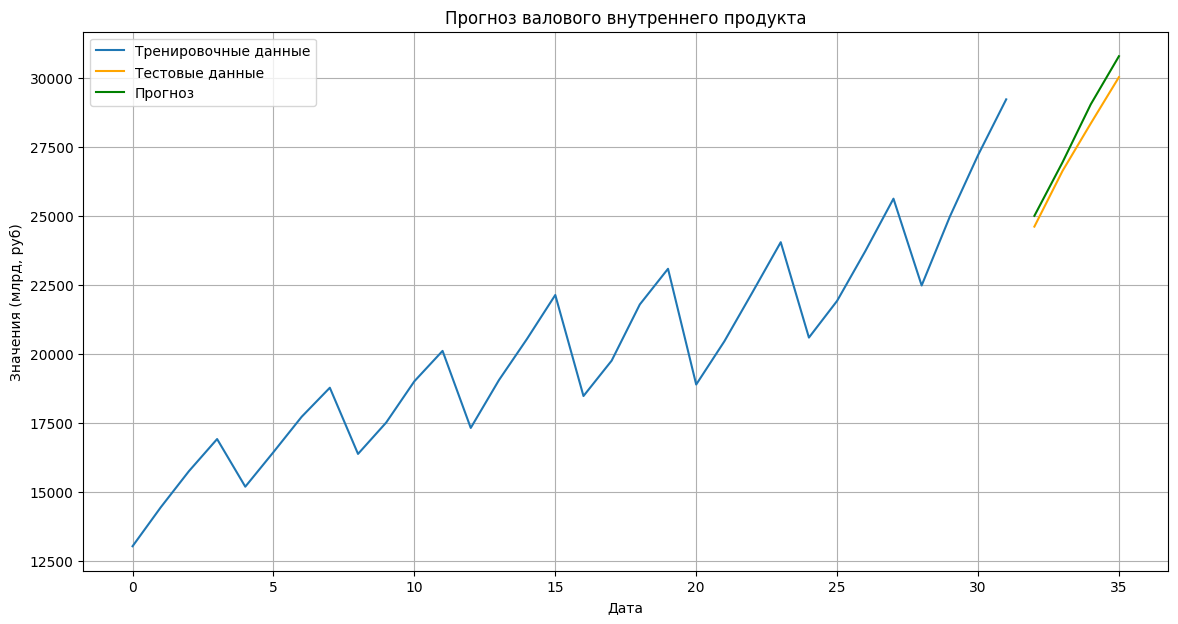

{'smoothing_level': 0.9596428571428571,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.04035714285714287,
 'damping_trend': nan,
 'initial_level': 15166.303663493447,
 'initial_trend': 364.74892006480263,
 'initial_seasons': array([0.91713357, 0.97027013, 1.03229188, 1.08030441]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [113]:
initial_season_length = model.season_length

train = data['Value'][:-initial_season_length]
test = data['Value'][-initial_season_length:]

hw_model = ExponentialSmoothing(
    train,
    seasonal='mul',
    seasonal_periods=initial_season_length,
    trend='add'
).fit()

# Прогноз на период тестовых данных
forecast = hw_model.forecast(len(test))

# Расчет метрик качества на тестовом периоде
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test.values - forecast.values) / test.values)) * 100

print(f"\nМетрики качества модели:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Сохраним параметры модели
model_params = hw_model.params

# Построим график прогноза
plt.figure(figsize=(14, 7))
plt.plot(train, label='Тренировочные данные')
plt.plot(test, label='Тестовые данные', color='orange')
plt.plot(forecast, label='Прогноз', color='green')
plt.legend()
plt.title('Прогноз валового внутреннего продукта')
plt.xlabel('Дата')
plt.ylabel('Значения (млрд, руб)')
plt.grid()
plt.show()

model_params